# Analisi Esplorativa Dataset ANAC l.190

Questo notebook effettua una breve analisi esplorativa del dataset ANAC e integra i dati con quelli in IndicePA e OpenConsip( estratti dal notebook *1_Analisi_IndicePA_OpenConsip*)

Poichè nelle analisi successive si analizzeranno solo i contratti avviati nel 2017, tutte le analisi esplorative in questo notebook e gli arricchimenti con altri dataset non riguarderanno l'intero dataset ANAC ma solo i bandi avvenuti nel 2017. 

Output: *data/anac/anac_indicepa.tsv* contiene tutti i bandi di gara avvenuti nel 2017 da parte di PA censite in indicePA.

**Note**
1. Sono stati estratti un totale di 4067641 gare, di cui 1990225 avvenute nell'anno 2017. Si procede all'analisi descrittiva di quest'ultimi bandi.
2. Molti data record contengono valori inconsistenti dovuti a typo (e.g. date con valori errate - 202/02/2016) o ad omissioni da parte delle PA (e.g. codici fiscali di strutture proponenti aventi valori nulli o uguali a *0*, codici fiscali di aggiudicatari offuscati o inesistenti). 


In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

In [2]:
#il dataset ANAC è scaricabile dal seguente url: https://cs2.cloudspc.it:8079/swift/v1/ANAC_dataset/crawled_data/anacDataset_1525953489668.csv

In [3]:
dir_file = "data/final_data/raw_data/"
f_anac = dir_file + "anacDataset_1525953489668.csv"
#df = pd.read_csv(f_anac, sep="\t", error_bad_lines=False, parse_dates=True)
df = pd.read_csv(f_anac, sep="\t", parse_dates=True, dtype= {"cfStrutturaProponente": str})

#ci sono typo in alcune date (e.g. 202/02/2016)
df['dataInizio'] = pd.to_datetime(df['dataInizio'], errors='coerce', format="%d/%m/%Y")
df['dataUltimazione'] = pd.to_datetime(df['dataUltimazione'], errors='coerce', format="%d/%m/%Y")

#pulisco i dati dalla string CDATA ed elimino spazi da i cf degli aggiudicatari
df.oggetto = df.oggetto.apply(lambda x :str(x).lower().replace('cdata', ''))
df.denominazionePrimoaggiudicatario = df.denominazionePrimoaggiudicatario.apply(lambda x :str(x).lower().replace('cdata', ''))
df.cfPrimoaggiudicatario = df.cfPrimoaggiudicatario.str.replace(' ', '')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4067642 entries, 0 to 4067641
Data columns (total 17 columns):
cig                                  object
cfStrutturaProponente                object
denominazioneStrutturaProponente     object
oggetto                              object
sceltaContraente                     object
importoAggiudicazione                float64
importoSommeLiquidate                float64
dataInizio                           datetime64[ns]
dataUltimazione                      datetime64[ns]
jsonPartecipanti                     object
jsonAggiudicatari                    object
totalePartecipanti                   int64
totaleAggiudicatari                  int64
totaleRaggruppamentopartecipanti     int64
totaleRaggruppamentoAggiudicatari    int64
cfPrimoaggiudicatario                object
denominazionePrimoaggiudicatario     object
dtypes: datetime64[ns](2), float64(2), int64(4), object(9)
memory usage: 527.6+ MB


## Analisi bandi 2017

Come già detto, da questo momento in poi si analizzeranno solo bandi e contratti avviati nel 2017.

Si estraggono per ogni aggiudicatario le seguenti informazioni:
- Numero contratti vinti (i.e. count);
- Ammontare totale aggiudicato (i.e. importoAggiudicazione);
- Ammontare totale liquidato (i.e. importoSommeLiquidate).

In [4]:
is_2017 = (df['dataInizio'] >= '01/01/2017') & (df['dataInizio'] <= '31/12/2017')
df_2017 = df.loc[is_2017]
print('Dimensione dataset originario', df.shape)
print('Dimensione dataset filtrato', df_2017.shape)


Dimensione dataset originario (4067642, 17)
Dimensione dataset filtrato (1990225, 17)


In [5]:
#estraggo numero di bandi e ammontare per aggiudicatario
df_cfPrimoaggiudicatario_count = df_2017[["cfStrutturaProponente", "cfPrimoaggiudicatario"]].groupby(["cfPrimoaggiudicatario"])["cfPrimoaggiudicatario"].agg(["count"]).reset_index(0)
df_cfPrimoaggiudicatario_sum = df_2017[["importoSommeLiquidate","importoAggiudicazione", "cfPrimoaggiudicatario"]].groupby(["cfPrimoaggiudicatario"]).sum().reset_index()

df_denominazione_aggiudicatario = df_2017[["cfPrimoaggiudicatario","denominazionePrimoaggiudicatario"]]
df_denominazione_aggiudicatario = df_denominazione_aggiudicatario.set_index("cfPrimoaggiudicatario")
df_denominazione_aggiudicatario = df_denominazione_aggiudicatario[~df_denominazione_aggiudicatario.index.duplicated(keep='first')]
#df_denominazione_aggiudicatario.head(3)

df_join = df_cfPrimoaggiudicatario_count.set_index('cfPrimoaggiudicatario').join(df_cfPrimoaggiudicatario_sum.set_index('cfPrimoaggiudicatario'))

#Si oseerva gi di qui che molti codici fiscali/ partite iva di aziende sono errati
df_join.head()

,count,importoSommeLiquidate,importoAggiudicazione
cfPrimoaggiudicatario,,,
,192,500134.58,1003833.43
0,379,1183332.90,2183924.53
00,6,37479.40,35086.09
000,26,32130.80,38109.36
0000,87,1421653.02,1662371.90


In [6]:
#Elimino i duplicati dalle denominazioni
df_denominazione_aggiudicatario = df_denominazione_aggiudicatario[~df_denominazione_aggiudicatario.index.duplicated(keep='first')]
final_df = pd.merge(df_denominazione_aggiudicatario, df_join, left_index=True, right_index=True, how='inner')
final_df.head()

,denominazionePrimoaggiudicatario,count,importoSommeLiquidate,importoAggiudicazione
cfPrimoaggiudicatario,,,,
03404540712,assigem srl,123,5.677880e+05,9.146164e+05
00477710552,tipolitografia federici snc ...,3,1.150000e+03,1.540000e+03
Raggruppamento,raggruppamento,78733,1.417035e+09,6.173817e+09
01640430243,libreria palazzo roberti,68,3.372552e+04,5.351900e+04
00043260140,credito valtellinese,37,2.770291e+04,2.331434e+05


### Top aziende, nel 2017, aggiudicatare in termini di gare vinte e importo aggiudicazione 

Le aggregazioni precedentemente estratte, permettono di estrarre informazioni circa le top aziende in termini di numero di gare vinte e importi aggiudicati. Questi dati aggregati non tengono conto di evenutali errori nei dati (e.g. typo) ed aziende caratterizzate da molteplici partite iva/ codici fiscali (e.g Maggioli SPA viene vista come due aziende distinte in quanto in alcuni bandi si fa riferimento al suo codice fiscale ed in altri casi si fa riferimento alla sua partita iva).

**Note**

1. Gli aggiudicatari dei bandi di gara possono essere sia singole aziende che raggruppamenti. In quest'ultimo caso il campo *cfPrimoaggiudicatario* e il campo *denominazionePrimoaggiudicatario* avranno valore *Raggruppamento*;
2. Ci sono 78733 bandi di gara vinti da raggruppamenti. Si dedica a questi data record una successiva analisi.

In [7]:
top_aggiuficatari = final_df.sort_values(['count', "importoAggiudicazione"], ascending=False)
top_aggiuficatari.head(15)

,denominazionePrimoaggiudicatario,count,importoSommeLiquidate,importoAggiudicazione
cfPrimoaggiudicatario,,,,
Raggruppamento,raggruppamento,78733,1.417035e+09,6.173817e+09
00150470342,gruppo spaggiari parma spa,15059,7.611607e+06,8.394848e+06
00488410010,telecom italia spa,12058,4.095627e+07,1.320545e+08
02027040019,borgione centro didattico srl,7530,3.481685e+06,4.013850e+06
03222970406,myo srl,7297,4.179742e+06,6.787292e+06
97103880585,poste italiane spa alt sud incassi conti di cr...,6444,1.317656e+07,4.824551e+07
13209130155,sigma aldrich,6319,3.571656e+06,5.743590e+06
06188330150,maggioli spa,6170,7.640338e+06,1.736380e+07
01114601006,poste italiane,6081,1.230133e+07,3.070426e+07


## Data quality

Si analizza di seguito la data quality del dataset in termini di missing data ed errori.

### Missing Data
Si osservano un gran numero di valori mancanti. In particolare, nei circa 4 milioni di bandi pubblici estratti, il 25% ha dei valori mancanti nel campo “data ultimazione”, il 15% nel campo “data inizio” e 1% nel campo "codice identificativo di gara" (CIG) e codice_fiscale/partita_iva del primo aggiudicatario (cfPrimoaggiudicatario). 

In [8]:
def get_percentage_missing(series):
    """ Calculates percentage of NaN values in DataFrame
    :param series: Pandas DataFrame object
    :return: float
    """
    num = series.isnull().sum()
    den = len(series)
    return round(num/den, 2)

[]

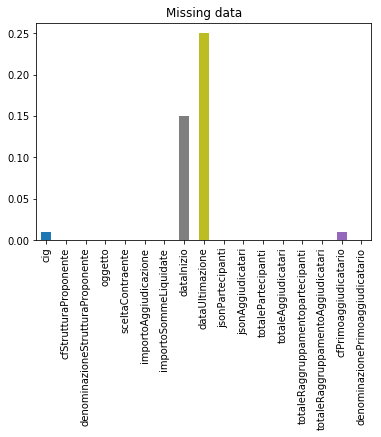

In [9]:
missing = get_percentage_missing(df)
missing.plot(kind="bar", title= "Missing data")
plt.plot()

## Analisi di qualità del dato

Si analizza di seguito alcune inconsistenze sugli attributi più importanti per le analisi successive.

### 1. Codici Fiscali / Partite Iva (feature *cfPrimoaggiudicatario*) 
Filtriamo in modo naive le partite iva (sequenze di numeri di lunghezza 11), codici fiscali (sequenza alfanumerica di dimensione 16) e partite iva comunitarie (stringhe le cui prime 2 cifre sono lettere e le successive 9 sono numeri). 



In [10]:
#filtra in modo naive, le partite iva ([0-9]{11}), i codici fiscali ([a-zA-Z0-9]{16}) e le partite iva comunitarie [a-zA-Z]{2}[0-9]{9}
correct_df = df[df.cfPrimoaggiudicatario.str.match("[0-9]{11}|[a-zA-Z0-9]{16}|[a-zA-Z]{2}[0-9]{9}", na=False)]
list_ = correct_df.cfPrimoaggiudicatario.unique()
tot_cf_unique = df.cfPrimoaggiudicatario.unique()

print('Numero cf/p.iva corrette: ', len(list_))
print('Percentuale cf/p.iva corrette: ', len(list_)/len(tot_cf_unique))
print('Numero bandi con cf/p.iva corrette secondo espressione regolare: ', correct_df.shape[0])
print('Percentuale bandi con cf/p.iva corrette secondo espressione regolare: ', correct_df.shape[0]/df.shape[0])

Numero cf/p.iva corrette:  467949
Percentuale cf/p.iva corrette:  0.9825411956393932
Numero bandi con cf/p.iva corrette secondo espressione regolare:  3740507
Percentuale bandi con cf/p.iva corrette secondo espressione regolare:  0.9195762557275198


Il dataset contiene diversi valori inconsistenti. Si analizzano di seguito alcuni esempi.

#### Esempio di codici fiscali "offuscati"

In [11]:
usa_df = df[df.cfPrimoaggiudicatario.str.contains("usa|USA", na=False)][["cig", "denominazioneStrutturaProponente", "cfPrimoaggiudicatario", "denominazionePrimoaggiudicatario"]]
usa_df.loc[[260132, 2170810, 2368922, 2659490, 3876650]]

,cig,denominazioneStrutturaProponente,cfPrimoaggiudicatario,denominazionePrimoaggiudicatario
260132,Z4018C7DA6,UNIVERSITA DEGLI STUDI DI FIRENZE,USA,american society for enology and viticulture
2170810,Z3F13CC9D3,UNIVERSITA DEGLI STUDI DI TORINO,USA,ieee
2368922,ZAB1DD6D52,PORTO CONTE RICERCHE SOCIETA A RESPONSABILITA ...,USA00000003,american dairy science association
2659490,6662974C13,RETE FERROVIARIA ITALIANA SOCIETA PER AZIONI ...,USA,meridium inc
3876650,ZDE1F2B7C4,AGENZIA REGIONALE PROTEZIONE AMBIENTALE ARPA P...,USA000000000,weebly inc


#### Esempio di aziende inconsistenti

Di seguito si analizza l'azienda [Diana Fea](https://dianafea.com/). Nel dataset esistono diversi aggiudicatari aventi simile denominazione (e.g. Diana Fea bv, TNO diana bv, tno diana bv3), ma con diverse p.iva (i.e. 810967704B01, NL810967704B01). 

In [12]:
df[df.cfPrimoaggiudicatario == "810967704B01"][["cig", "importoAggiudicazione", "cfPrimoaggiudicatario", "denominazionePrimoaggiudicatario"]]

,cig,importoAggiudicazione,cfPrimoaggiudicatario,denominazionePrimoaggiudicatario
19674,Y3B1E73896,2150.0,810967704B01,diana fea bv
25486,Z961839C92,1955.0,810967704B01,diana fea bv
719053,Z221D7035E,5200.0,810967704B01,tno diana bv
2542548,Z57092BAA8,5546.0,810967704B01,tno diana bv
2542683,Z5B0F5AE25,5562.0,810967704B01,tno diana bv
2544875,ZA7144D854,11000.0,810967704B01,tno diana bv


In [13]:
df[df.cfPrimoaggiudicatario == "NL810967704B01"][["cig", "importoAggiudicazione", "cfPrimoaggiudicatario", "denominazionePrimoaggiudicatario"]]

,cig,importoAggiudicazione,cfPrimoaggiudicatario,denominazionePrimoaggiudicatario
260082,ZB118988CA,2400.0,NL810967704B01,tno diana
2542228,Z4B1934229,5500.0,NL810967704B01,tno diana bv3
2544567,Z9C1E25EFC,4000.0,NL810967704B01,tno diana bv3


### 2. Date

Esistono alcuni data record la cui data di inzio del contratto (feature *dataInizio*) è successiva alla data di ultimazione (feature dataUltimazione).

In [14]:
df_inconsistent_dates = df[df.dataInizio > df.dataUltimazione][["cig", "importoAggiudicazione", "cfPrimoaggiudicatario", "denominazionePrimoaggiudicatario", "dataInizio", "dataUltimazione"]]

print('Numero bandi con inconsistenze nelle date: ', df_inconsistent_dates.shape[0])
df_inconsistent_dates.head()

Numero bandi con inconsistenze nelle date:  16009


,cig,importoAggiudicazione,cfPrimoaggiudicatario,denominazionePrimoaggiudicatario,dataInizio,dataUltimazione
333,Z551B7FF8D,105.92,00488410010,telecom italia,2016-10-01,2016-09-30
404,ZC91BCAB9D,80.00,02462790201,alkemica,2016-12-12,2016-05-31
445,Z961B71AF9,3248.00,02309980205,bp consulenza e servizi ss,2016-10-08,2016-06-03
446,ZE51BEF894,1200.00,02150300206,porta aperta societa cooperativa sociale,2016-11-15,2016-05-31
490,ZA41C8BCE7,200.00,VGLGPR61P11L219A,i me t di avogliero gianpiero,2016-09-29,2016-09-12


### 3. CIG
Ci sono dei bandi di gara registrati con CIG apparentemente non conformi, come per esempio CIG composti solo da zeri. Tuttavia questi elementi rappresentano nella maggior parte dei casi contratti realizzati con pagamenti in contanti, per i quali ANAC non fornisce un codice identificativo.

Infine è possibile trovare nel dataset cig duplicati.

In [15]:
print('Esempio CIG inconsistenti')
#df[df.cig == "0000000000"][["cig", "denominazioneStrutturaProponente", "cfPrimoaggiudicatario", "denominazionePrimoaggiudicatario"]].head()
wrong_cig = df[df.cig.apply(lambda x:  len(set([c for c in str(x)])) == 1)]
less_500 = wrong_cig[wrong_cig.importoAggiudicazione < 500].shape

print('Numero bandi con cig composti di sequenze di un solo carattere: ', wrong_cig.shape[0])
print('Numero bandi con cig composti di sequenze di un solo carattere e ammontare < 500 euro : ',less_500[0])
wrong_cig.head()

Esempio CIG inconsistenti
Numero bandi con cig composti di sequenze di un solo carattere:  157615
Numero bandi con cig composti di sequenze di un solo carattere e ammontare < 500 euro :  109994


,cig,cfStrutturaProponente,denominazioneStrutturaProponente,oggetto,sceltaContraente,importoAggiudicazione,importoSommeLiquidate,dataInizio,dataUltimazione,jsonPartecipanti,jsonAggiudicatari,totalePartecipanti,totaleAggiudicatari,totaleRaggruppamentopartecipanti,totaleRaggruppamentoAggiudicatari,cfPrimoaggiudicatario,denominazionePrimoaggiudicatario
2285,0000000000,00341490126,COMUNE DI GORLA MAGGIORE,rinnovo quota associativa anutel 2016,23AFFIDAMENTO IN ECONOMIA AFFIDAMENTO DIRETTO,250.00,250.00,2016-01-01,2016-12-31,"{""raggruppamento"":[],""partecipante"":[{""codiceF...","{""aggiudicatarioRaggruppamento"":[],""aggiudicat...",1,1,0,0,99330670797,anutel
3931,,83000750782,ISTITUTO TECNICO INDUSTRIALE STATALE,saldo fattura n 142365 del 14 ottobre 2014,23AFFIDAMENTO IN ECONOMIA AFFIDAMENTO DIRETTO,310.40,0.00,2014-12-30,NaT,"{""raggruppamento"":[],""partecipante"":[{""codiceF...","{""aggiudicatarioRaggruppamento"":[],""aggiudicat...",1,1,0,0,00894091008,tecnochimica moderna
4897,0000000000,85002210046,COMUNE DI SANFRONT,progetto yepp monviso liquidazione quota anno ...,01PROCEDURA APERTA,111357.70,0.00,NaT,NaT,"{""raggruppamento"":[],""partecipante"":[{""codiceF...","{""aggiudicatarioRaggruppamento"":[],""aggiudicat...",1,1,0,0,03553360045,unione montana comuni del monviso
6905,0000000000,80004340214,CONSIGLIO DELLA PROVINCIA AUTONOMA DI BOLZANO,canone speciale televisione per lanno 2016,23AFFIDAMENTO IN ECONOMIA AFFIDAMENTO DIRETTO,391.68,391.68,2016-01-01,2016-12-31,"{""raggruppamento"":[],""partecipante"":[{""codiceF...","{""aggiudicatarioRaggruppamento"":[],""aggiudicat...",1,1,0,0,06382641006,rai radiotelevisione italiana spa
6906,0000000000,80004340214,CONSIGLIO DELLA PROVINCIA AUTONOMA DI BOLZANO,spese postali per pagamento canone televisione,23AFFIDAMENTO IN ECONOMIA AFFIDAMENTO DIRETTO,1.50,1.50,2016-02-19,2016-02-19,"{""raggruppamento"":[],""partecipante"":[{""codiceF...","{""aggiudicatarioRaggruppamento"":[],""aggiudicat...",1,1,0,0,01114601006,poste italiane spa


In [16]:

print('Esempio cig duplicati')
#df[df.duplicated(["cig"], keep=False)]["cig"].values[:100]#[["cig", "denominazioneStrutturaProponente", "cfPrimoaggiudicatario", "denominazionePrimoaggiudicatario"]]
df[df.cig.str.contains("ZA41C8BCE7|Z561B5BA67|Z7208F43BF|Z6F187DE25", na=False)].sort_values("cig")[["cig", "denominazioneStrutturaProponente", "cfPrimoaggiudicatario", "denominazionePrimoaggiudicatario", "importoAggiudicazione"]]

Esempio cig duplicati


,cig,denominazioneStrutturaProponente,cfPrimoaggiudicatario,denominazionePrimoaggiudicatario,importoAggiudicazione
1124,Z561B5BA67,COMUNE DI CAVALLASCA,Raggruppamento,raggruppamento,0.00
1738432,Z561B5BA67,COMUNE DI SAN FERMO DELLA BATTAGLIA,Raggruppamento,raggruppamento,2745.00
1280,Z6F187DE25,AGENZIA REGIONALE PER I SERVIZI EDUCATIVI E PE...,01795380359,gesta spa,0.00
1454,Z6F187DE25,AGENZIA REGIONALE PER I SERVIZI EDUCATIVI E PE...,09336350153,gesta spa,888.33
2982,Z7208F43BF,COMUNE DI CORRIDONIA,01149060434,ristoralta srl,377.27
2986,Z7208F43BF,COMUNE DI CORRIDONIA,01040390435,gps snc di mazzaferro g eamp c,600.00
490,ZA41C8BCE7,VIII REPARTO MOBILE POLIZIA DI STATO,VGLGPR61P11L219A,i me t di avogliero gianpiero,200.00
222324,ZA41C8BCE7,8 REPARTO VOLO POLIZIA DI STATO,VGLGPR61P11L219A,i me t di avogliero gianpiero,200.00


In [17]:
#%who
del [df_denominazione_aggiudicatario, df_join, missing, wrong_cig, df_inconsistent_dates, usa_df, correct_df, list_, df_cfPrimoaggiudicatario_count, tot_cf_unique, df_cfPrimoaggiudicatario_sum, get_percentage_missing, is_2017, less_500]

## Integrazione dati ANAC con IndicePA

Il file *"data/indicePA/indicePA.tsv"* è stato estratto a partire dal notebook *Analisi IndicePA*.

**Note**

- Anno 2017: Su 1.842.313 bandi di gara, solo 1.321.761 hanno codici fiscali di strutture proponenti validi. Questo è dovuto al fatto che alcuni codici fiscali sono errati, mentre altri sono codici fiscali di SPA (non censite in IndicePA). Il dataframe è salvato in *data/anac/anac_indicepa_2017.tsv*
- Tutti gli anni: Su 3.913.440  bandi di gara, 2.682.931 hanno codici fiscali di strutture proponenti validi.

In [18]:
f_indicePA = "data/indicePA/indicePA.tsv"
#df_indicePA = pd.read_csv(f_indicePA, sep="\t")
df_indicePA = pd.read_csv(f_indicePA, sep="\t",dtype={'cf': str})

df_indicePA = df_indicePA.rename(columns={'cf': 'cfStrutturaProponente'})
df_indicePA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13941 entries, 0 to 13940
Data columns (total 8 columns):
cfStrutturaProponente    13941 non-null object
cod_amm                  13941 non-null object
regione                  13941 non-null object
provincia                13493 non-null object
comune                   13941 non-null object
indirizzo                13941 non-null object
tipologia_istat          13941 non-null object
tipologia_amm            13941 non-null object
dtypes: object(8)
memory usage: 871.4+ KB


### ANNO 2017

In [19]:
print('Numero PA presenti sia in indicePA che in ANAC: ', df_indicePA.shape[0])
print("Dimensione Dataset ANAC per l' anno 2017: ",df_2017.shape[0])

Numero PA presenti sia in indicePA che in ANAC:  13941
Dimensione Dataset ANAC per l' anno 2017:  1990225


In [20]:
df_2017_indicePA = pd.merge(df_2017, df_indicePA, left_on="cfStrutturaProponente", right_on="cfStrutturaProponente", how='inner')
df_2017_indicePA.to_csv(dir_file + "anac_indicepa_2017.tsv", sep="\t")

diff = df_2017.shape[0] - df_2017_indicePA.shape[0]
print("Gare di PA non censite su indicePA: ", diff)
print('Dimensione dataset con inner join ', df_2017_indicePA.shape)

Gare di PA non censite su indicePA:  215629
Dimensione dataset con inner join  (1774596, 24)


In [21]:
df_2017_indice_left = pd.merge(df_2017, df_indicePA, left_on="cfStrutturaProponente", right_on="cfStrutturaProponente", how='left')
pd.to_pickle(df_2017_indice_left, dir_file + "anac_indicepa_2017.pickle")

print('Dimensione dataset con left join ', df_2017_indicePA.shape)

Dimensione dataset con left join  (1774596, 24)


In [22]:
#del [df_2017_indice_left, df_2017_indicePA, df_2017, final_df, top_aggiuficatari]

### Tutti gli anni

In [23]:
df_all_indicePA = pd.merge(df, df_indicePA, left_on="cfStrutturaProponente", right_on="cfStrutturaProponente", how='inner')
#df_all_indicePA.to_csv(dir_file + "anac_indicepa_all.tsv", sep="\t")
pd.to_pickle(df_all_indicePA, dir_file + "anac_indicepa_all.pickle")

diff = df.shape[0] - df_all_indicePA.shape[0]
print("Gare di PA non recensite su indicePA: %d (su %d gare totali)" % (diff, df.shape[0]))

Gare di PA non recensite su indicePA: 549157 (su 4067642 gare totali)


## Integrazione dati ANAC con OpenConsip

Il file *"data/consip/fornitori.pickle"* è stato estratto a partire dal notebook *1_Analisi_IndicePA_OpenConsip*.


In [24]:
f_consip = "data/consip/fornitori.pickle"

df_consip = pd.read_pickle(f_consip)

df_consip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110251 entries, 0 to 72996
Data columns (total 12 columns):
#Partita_Iva               110251 non-null object
Ragione_Sociale            110251 non-null object
Forma_Societaria           110214 non-null object
Nazione_Sede_legale        110248 non-null object
Regione_Sede_legale        110236 non-null object
Provincia_Sede_legale      110236 non-null object
Comune_Sede_legale         110236 non-null object
Indirizzo_Sede_legale      110245 non-null object
Numero_Aggiudicazioni      110251 non-null int64
Numero_Abilitazioni        110251 non-null int64
Numero_Transazioni         110251 non-null int64
Numero_Contratti_attivi    110251 non-null int64
dtypes: int64(4), object(8)
memory usage: 10.9+ MB


In [30]:
#questo dataset verrà usato nel processo di generazione del grafo dei competitor (notebook 6_Graph_layer_generation) 
df_anac_consip = pd.merge(df_2017_indice_left, df_consip, left_on='cfPrimoaggiudicatario', right_on='#Partita_Iva')
pd.to_pickle(df_all_indicePA, dir_file + "anac_consip_2017.pickle")